# Analysing Collective Behaviour in Temporal Networks Using Event Graphs and Temporal Motifs

This notebook covers the analysis for the paper "Analysing Collective Behaviour in Temporal Networks Using Event Graphs and Temporal Motifs" and replicates the analysis and figures.

The paper is available to view on [ArXiv](https://arxiv.org/abs/1801.10527).

There are three notebooks available to view:
* `main.ipynb`: This notebook, covering all analysis and figure production.
* `interval-split.ipynb`: Specific analysis relating to the fixed-width interval decomposition.
* `ensemble.ipynb`: Code to generate and save an ensemble of event graphs.

In [6]:
%pylab inline

import pandas as pd
import seaborn as sns
from sklearn.preprocessing import Normalizer

from eventgraphs import EventGraph

Populating the interactive namespace from numpy and matplotlib


In [38]:
PLOT_STYLE = {'lines.linewidth':2,
              'font.size':16,
              'xtick.labelsize':16,
              'ytick.labelsize':16,
              'axes.labelsize' : 16,
              'mathtext.fontset':'cm',
              'mathtext.rm' :'serif',
              'text.usetex':False
             }

## 1. Loading Data

Data available to download [here](https://raw.githubusercontent.com/empiricalstateofmind/eventgraphs/master/examples/collective_behaviour_paper/data/twitter_24h.csv).
Alternatively it is included in this repository.

In [2]:
data = pd.read_csv('./data/twitter_24h.csv', header=0)
len(data)

130360

## 2. Building Event Graph

In [3]:
EG = EventGraph.from_pandas_eventlist(data, graph_rules='teg')
EG.event_graph_rules['delta_cutoff']=1e9

In [4]:
EG.build(verbose=True)

In [5]:
EG.calculate_edge_motifs(edge_type='type')

In [6]:
EG.save('./data/eventgraph.json')

## 3. Decomposition

In [3]:
# Load from file if already built.
# EG = EventGraph.from_file('./data/eventgraph.json')

In [172]:
z = pd.Series(EG.connected_components_indices()).value_counts()
print("Number of connected components: {}".format(len(z)))
print("Number of connected components (with more than 4 events): {}".format(len(z[z>4])))

Number of connected components: 3625
Number of connected components (greater than 4 events): 329


### FIGURE A1 - Temporal Decomposition

In [4]:
from eventgraphs.analysis import calculate_component_distribution_over_delta

dt_range = np.linspace(0,3600, 100)
EG.generate_eg_matrix()
dists, maxs = calculate_component_distribution_over_delta(EG, dt_range)

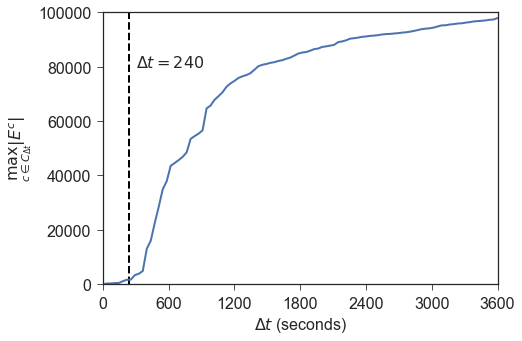

In [92]:
with plt.style.context(['seaborn-paper', PLOT_STYLE]):

    fig = plt.figure(figsize=(5*np.sqrt(2),5))
    ax = fig.add_subplot(111)

    maxs.plot(ax=ax);

    ax.vlines(240,0,100000, alpha=1, linestyle='--')
    ax.text(300, 80000, r"$\Delta t=240$")


    ax.set_xlabel(r"$\Delta t$ (seconds)")
    ax.set_ylabel(r"$\max_{c \in C_{\Delta t}} |E^c|$")

    ax.set_xticks(np.linspace(0,3600,7))

    ax.set_xlim(0,3600)
    ax.set_ylim(0,100000)

    fig.savefig('./figures/figure_a1_deltat.eps', bbox_inches='tight')

In [40]:
filtered = EG.filter_edges(delta_ub=240)

### FIGURE 2 - Temporal Barcode

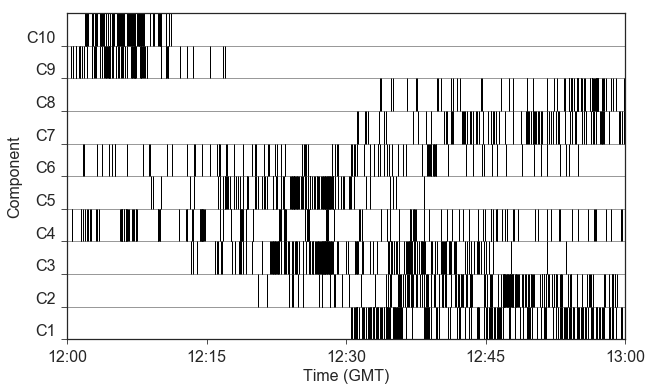

In [41]:
from eventgraphs.plotting import plot_barcode

with plt.style.context(['seaborn-paper', PLOT_STYLE]):

    start = 43200
    interval = 3600
    subset = EG.events[(EG.events.time>start) & (EG.events.time<=start+interval)]
    featured_data = EG.filter_events(subset.index)

    fig = plt.figure(figsize=(10,6))
    ax = fig.add_subplot(111)

    plot_barcode(featured_data, delta_ub=240, top=10, ax=ax);

    ax.set_xticks(np.linspace(start, start+interval, 5))
    ax.set_xticklabels([pd.to_datetime(x, unit='s').strftime('%H:%M') for x in np.linspace(start, start+interval, 5)])

    ax.set_xlabel('Time (GMT)')
    ax.set_ylabel('Component')

    fig.savefig('./figures/figure_2_barcode.eps', bbox_inches='tight')

## 4. Feature Generation

In [42]:
from eventgraphs.clustering import generate_features, FEATURE_SPEC

components = filtered.connected_components(min_size=5)
len(components)

4137

In [43]:
FEATURE_SPEC['event_graph_features'][1]['kwargs'] = {'miller_correct':False, 'k':24}
FEATURE_SPEC['event_graph_features'][2]['kwargs'] = {'miller_correct':False, 'divisions':10}
FEATURE_SPEC['event_graph_features']

[{'function': <function eventgraphs.analysis.calculate_motif_distribution>,
  'kwargs': {},
  'name': 'motifs',
  'scale': False},
 {'function': <function eventgraphs.analysis.calculate_motif_entropy>,
  'kwargs': {'k': 24, 'miller_correct': False},
  'name': 'motif_entropy',
  'scale': False},
 {'function': <function eventgraphs.analysis.calculate_iet_entropy>,
  'kwargs': {'divisions': 10, 'miller_correct': False},
  'name': 'iet_entropy',
  'scale': False},
 {'function': <function eventgraphs.analysis.calculate_activity>,
  'kwargs': {},
  'name': 'activity',
  'scale': False},
 {'function': <function eventgraphs.clustering.<lambda>>,
  'kwargs': {},
  'name': 'duration',
  'scale': True},
 {'function': <function eventgraphs.clustering.<lambda>>,
  'kwargs': {},
  'name': 'num_events',
  'scale': True},
 {'function': <function eventgraphs.clustering.<lambda>>,
  'kwargs': {},
  'name': 'num_nodes',
  'scale': True}]

In [44]:
features, scale_features = generate_features(components, feature_spec=FEATURE_SPEC)

**Note:** The eventgraphs package uses a different motif representation than in the paper, due to the requirement of generalising to motifs of higher-order interactions. These translate to

1. +|○ : ABCB
2. +|● : ABCA
3. ○|● : ABBA
4. ○|+ : ABBC
5. ●|○ : ABAB
6. ●|+ : ABAC


In [45]:
features.describe()

,"+|○ (mm,mm)","+|○ (mm,rr)","+|○ (rr,mm)","+|○ (rr,rr)","+|● (mm,mm)","+|● (mm,rr)","+|● (rr,mm)","+|● (rr,rr)",activity,clustering_coefficient,...,"○|● (rr,mm)","○|● (rr,rr)","●|+ (mm,mm)","●|+ (mm,rr)","●|+ (rr,mm)","●|+ (rr,rr)","●|○ (mm,mm)","●|○ (mm,rr)","●|○ (rr,mm)","●|○ (rr,rr)"
count,4137.000000,4137.00000,4137.000000,4137.000000,4137.000000,4137.000000,4137.000000,4137.000000,4137.000000,4137.000000,...,4137.000000,4137.000000,4137.000000,4137.000000,4137.000000,4137.000000,4137.000000,4137.000000,4137.000000,4137.000000
mean,0.146522,0.00775,0.010551,0.440305,0.019522,0.023966,0.003537,0.001348,0.083054,0.052876,...,0.011145,0.000006,0.025353,0.000626,0.000264,0.055360,0.042163,0.000193,0.000257,0.129440
std,0.299774,0.03472,0.040021,0.386976,0.059497,0.062228,0.023097,0.013264,0.179929,0.178200,...,0.045824,0.000355,0.086852,0.010300,0.005202,0.140406,0.128532,0.005613,0.005472,0.213331
min,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.005712,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.017603,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.00000,0.000000,0.428571,0.000000,0.000000,0.000000,0.000000,0.029596,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.086957,0.00000,0.000000,0.800000,0.000000,0.000000,0.000000,0.000000,0.052897,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.200000
max,1.000000,0.50000,0.400000,1.000000,0.500000,0.500000,0.500000,0.250000,0.993262,1.000000,...,0.500000,0.022727,1.000000,0.333333,0.200000,1.000000,1.000000,0.250000,0.166667,1.000000


In [46]:
# Rescale
rs_features = Normalizer().fit_transform(features)
rs_features = pd.DataFrame(rs_features, index=features.index, columns=features.columns)

## 5. Clustering

In [47]:
from sklearn.metrics import silhouette_score
from eventgraphs.clustering import find_clusters

### FIGURE A2 - Silhouette Coefficients

In [181]:
scores = {}
for cluster_size in range(2,31):
    clusters, cluster_centers = find_clusters(rs_features, max_clusters=cluster_size, metric='euclidean')
    scores[cluster_size] = silhouette_score(rs_features, clusters)
scores = pd.Series(scores)

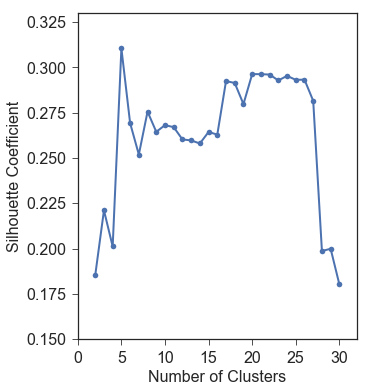

In [182]:
with plt.style.context(['seaborn-paper', PLOT_STYLE]):

    fig = plt.figure(figsize=(5,6))
    ax = fig.add_subplot(111)

    scores.plot(marker='o', ax=ax)

    ax.set_xlabel("Number of Clusters")
    ax.set_ylabel("Silhouette Coefficient")

    ax.set_xlim(0,32)
    ax.set_ylim(0.15,0.33)

    ax.set_xticks(np.arange(0,33,5));

    fig.savefig('./figures/figure_a2a_clusters.eps', bbox_inches='tight')

In [51]:
max_clusters = 5
clusters, cluster_centers = find_clusters(rs_features, max_clusters=max_clusters, metric='euclidean')
filtered.add_cluster_assignments(clusters)

In [52]:
filtered.events_meta.cluster.value_counts().sort_index()

0    42974
1     5987
2    32118
3     5339
4    32660
5    11282
Name: cluster, dtype: int64

### TABLE 2 - Cluster Summary Statistics

In [137]:
summary = pd.concat([features.groupby(by=clusters).mean(),
                     scale_features.groupby(by=clusters).mean()],
                     axis=1)

variances = pd.concat([features.groupby(by=clusters).std(),
                     scale_features.groupby(by=clusters).std()],
                     axis=1)

def reduce_motif(motif):
    if motif.startswith('○|●'):
        return 'ABBA'
    elif motif.startswith('●|+'):
        return 'ABAC'
    elif motif.startswith('○|+'):
        return 'ABBC'
    elif motif.startswith('+|●'):
        return 'ABCA'
    elif motif.startswith('+|○'):
        return 'ABCB'
    elif motif.startswith('●|○'):
        return 'ABAB'
    else:
        return motif 
    
summary = summary.T.reset_index()
summary = summary.groupby(by=summary['index'].apply(reduce_motif)).sum()

# Transform back to original features (rather than normalised) for easier comparison
summary.loc['activity'] = -np.log(1-summary.loc['activity'])
for f in ('ii','oi','oo'):
    summary.loc['imbalance_{}'.format(f)] = 2*summary.loc['imbalance_{}'.format(f)] - 1
summary.loc['iet_entropy'] = summary.loc['iet_entropy']*np.log2(10)
summary.loc['motif_entropy'] = summary.loc['motif_entropy']*np.log2(24)
    
summary

,1,2,3,4,5
index,,,,,
ABAB,0.091253,0.115510,0.341988,0.185538,0.162652
ABAC,0.067238,0.048298,0.395942,0.018583,0.084766
ABBA,0.279061,0.109526,0.001018,0.000333,0.012746
ABBC,0.117049,0.079053,0.017930,0.000625,0.013684
ABCA,0.158230,0.114103,0.013716,0.000910,0.018768
ABCB,0.287169,0.533510,0.229406,0.794012,0.707384
activity,0.030582,0.033640,0.570066,0.055475,0.030053
clustering_coefficient,0.410728,0.020139,0.018083,0.000387,0.015947
duration,541.993151,686.017526,166.361364,454.899134,750.829123


### FIGURE 3 - Feature-space Plot

In [ ]:
from eventgraphs.clustering import reduce_feature_dimensionality
from eventgraphs.plotting import plot_component_embedding

X, (tsne, _) = reduce_feature_dimensionality(rs_features, 
                                             ndim=2, 
                                             method='tsne', 
                                             return_scalers=True, 
                                             **dict(random_state=0, 
                                                  verbose=True, 
                                                  learning_rate=500),)

Y, PCA = reduce_feature_dimensionality(rs_features, 
                                       ndim=3, 
                                       method='pca', 
                                       return_scalers=True,) 

In [138]:
print("Explained Ratio: {}".format(PCA.explained_variance_ratio_))
print("Total Explained: {}".format(sum(PCA.explained_variance_ratio_)))

Explained Ratio: [ 0.36414586  0.19057942  0.15490228]
Total Explained: 0.7096275624926405


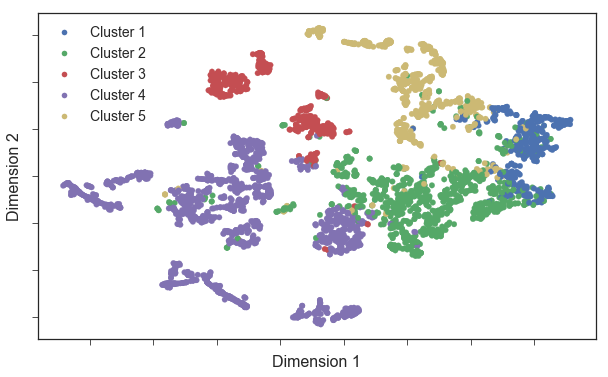

In [121]:
with plt.style.context(['seaborn-paper', PLOT_STYLE, {'legend.fontsize':14,
                                                      'legend.frameon':False}]):

    fig = plt.figure(figsize=(10,6))
    ax = fig.add_subplot(111)

    ax = plot_component_embedding(X, clusters=clusters, ax=ax);

    fig.savefig('./figures/figure_3_clustering.eps', bbox_inches='tight')

### TABLE 1 - Principal Component Analysis

In [115]:
pca_components = pd.DataFrame([features.columns[pd.Series(PCA.components_[0]).abs().nlargest(3).index],
                               features.columns[pd.Series(PCA.components_[1]).abs().nlargest(3).index],
                               features.columns[pd.Series(PCA.components_[2]).abs().nlargest(3).index]]).T
pca_components.columns = ['Component 1 ({:.0f}%)'.format(100*PCA.explained_variance_ratio_[0]), 
                          'Component 2 ({:.0f}%)'.format(100*PCA.explained_variance_ratio_[1]),
                          'Component 3 ({:.0f}%)'.format(100*PCA.explained_variance_ratio_[2])]
pca_components

,Component 1 (36%),Component 2 (19%),Component 3 (15%)
0,"+|○ (rr,rr)","+|○ (mm,mm)",iet_entropy
1,imbalance_oi,imbalance_oi,"●|○ (rr,rr)"
2,"+|○ (mm,mm)",motif_entropy,reciprocity_ratio


### FIGURE 4 - Dendrogram

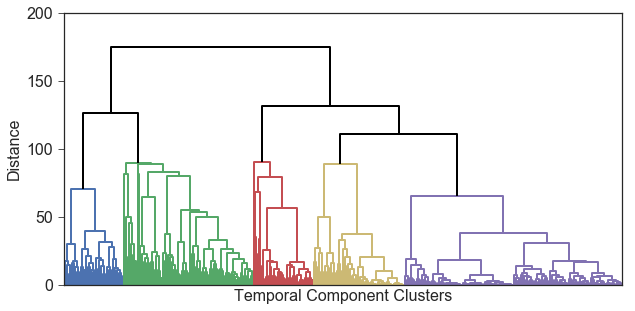

In [78]:
from eventgraphs.clustering import generate_distance_matrix, generate_linkage
from eventgraphs.plotting import plot_component_dendrogram
from scipy.cluster.hierarchy import set_link_color_palette

distances = generate_distance_matrix(rs_features)
Z = generate_linkage(distances)

with plt.style.context(['seaborn-paper', PLOT_STYLE]):

    fig = plt.figure(figsize=(10,5))
    ax = fig.add_subplot(111)

    set_link_color_palette(['C0', 'C1', 'C2', 'C4', 'C3',])

    plot_component_dendrogram(Z, dendrogram_kwargs={'leaf_rotation': 90, 
                                 'no_labels': True, 
                                 'distance_sort': False, 
                                 'count_sort': True,
                                 'above_threshold_color': 'k', 'color_threshold': 95}, ax=ax);

    ax.set_xlabel("Temporal Component Clusters")
    ax.set_ylim(0,200)

    fig.savefig('./figures/figure_4_hierarchy.eps', bbox_inches='tight')

### FIGURE 5 - Representative Examples

In [79]:
from eventgraphs.plotting import plot_aggregate_graph
EVENT_CMAP = {'m':'darkgreen', 'r':'red'}

for c,ix in [(1,1),(2,3),(3,2),(4,2),(5,1)]:

    cfeatures = rs_features.loc[clusters[clusters==c].index]
    differences = ((cfeatures - cfeatures.mean())**2).mean(axis=1)
    component_ix = differences.nsmallest(5).index[ix]

    featured_component = filtered.get_component(component_ix)

    A = plot_aggregate_graph(featured_component, edge_colormap=EVENT_CMAP, display=False)

    charmap = {1:'a',2:'b',3:'c',4:'d',5:'e',}
    with open('./figures/figure_5{}_examples.eps'.format(charmap[c]), 'wb') as file:
        file.write(A.create(format='eps'))

### FIGURE 6 - Evolution Over Time

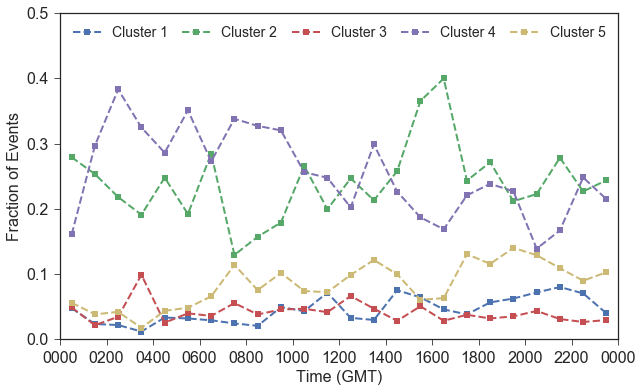

In [144]:
from eventgraphs.plotting import plot_cluster_timeseries

with plt.style.context(['seaborn-paper', PLOT_STYLE, {'legend.fontsize':14,
                                                      'legend.frameon':False}]):

    fig = plt.figure(figsize=(10,6))
    ax = fig.add_subplot(111)

    plot_cluster_timeseries(filtered, interval_width=3600, normalized=True, plot_unclustered=False, ax=ax);

    ax.set_xlabel("Time (GMT)")
    ax.set_ylabel("Fraction of Events")

    ax.set_xlim(0,23.5)
    ax.set_ylim(0.0,0.5)

    ax.set_xticks(np.linspace(-0.5,23.5,13))
    ax.set_xticklabels([pd.to_datetime(x, unit='h').strftime("%H%M") for x in np.linspace(0,24,13)])

    legend = ax.legend(ncol=5, mode='expand')
    [x.set_text('Cluster {}'.format(x.get_text())) for x in legend.get_texts()]

    fig.savefig('./figures/figure_6_evolution.eps', bbox_inches='tight')

## 6. Comparison with Fixed-Interval Binning

See ``interval-split.ipynb`` for more detailed analysis.

In [67]:
average_length = scale_features['duration'].mean()
average_length

535.763596809282

In [68]:
intervals = {}
interval_width = average_length
for ix, start in enumerate(np.arange(0, 86400, interval_width)):
    interval = data[(data.time>=start) & (data.time<start+interval_width)]
    eg = EventGraph.from_pandas_eventlist(interval, graph_rules='teg')
    eg.build()
    eg.calculate_edge_motifs(edge_type='type')
    intervals[ix] = eg
len(intervals)

162

In [69]:
interval_features, interval_scale_features = generate_features(intervals, feature_spec=FEATURE_SPEC)

In [70]:
# Rescale
rs_interval_features = Normalizer().fit_transform(interval_features)
rs_interval_features = pd.DataFrame(rs_interval_features, index=interval_features.index, columns=interval_features.columns)

In [71]:
scores = {}
for cluster_size in range(2,31):
    interval_clusters, interval_cluster_centers = find_clusters(rs_interval_features, max_clusters=cluster_size)
    scores[cluster_size] = silhouette_score(rs_interval_features, interval_clusters)
scores = pd.Series(scores)

### FIGURE A2 - Silhouette Coefficient

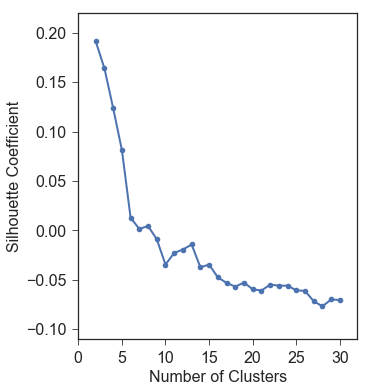

In [179]:
with plt.style.context(['seaborn-paper', PLOT_STYLE]):
    
    fig = plt.figure(figsize=(5,6))
    ax = fig.add_subplot(111)

    scores.plot(marker='o', ax=ax)

    ax.set_xlabel("Number of Clusters")
    ax.set_ylabel("Silhouette Coefficient")

    ax.set_xlim(0,32)
    ax.set_ylim(-0.11,0.22)

    ax.set_xticks(np.arange(0,33,5));

    fig.savefig('./figures/figure_a2b_clusters.eps', bbox_inches='tight')

In [73]:
max_clusters = 2
interval_clusters, interval_cluster_centers = find_clusters(rs_interval_features, max_clusters=max_clusters)

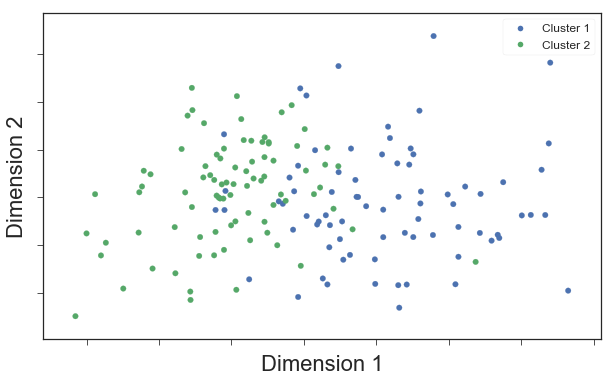

In [74]:
X = reduce_feature_dimensionality(rs_interval_features, ndim=2, method='pca')
plot_component_embedding(X, clusters=interval_clusters);

### FIGURE 7 - Interval Examples

In [80]:
for c,letter in zip(range(1,max_clusters+1),('a','b','c','d','e')):

    component_ix = ((rs_interval_features.loc[interval_clusters[interval_clusters==c].index] - interval_cluster_centers[c])**2).mean(axis=1).nsmallest(5).index[1]

    featured_component = intervals[component_ix]

    A = plot_aggregate_graph(featured_component, edge_colormap=EVENT_CMAP, display=False)

    with open('./figures/figure_7{}_interval.eps'.format(letter), 'wb') as file:
        file.write(A.create(format='eps'))

### Decomposition into interval components

In [158]:
# How many temporal components are split up by the intervals?

split_components = {}
    
for interval_width in np.arange(60,1201, 60):
    print(interval_width, end='\r')
    interval_split = np.arange(0, 86400, interval_width)
    count = 0
    for ix, comp in components.items():
        a = comp.events.iloc[0].time
        b = comp.events.iloc[-1].time

        if np.searchsorted(interval_split, a) != np.searchsorted(interval_split, b):
            # Component spans multiple intervals
            count += 1
    split_components[interval_width] = count
    
split_components = pd.Series(split_components)

In [173]:
# How many components are there?

num_components = {}

for interval_width in np.arange(60,1201, 60):
    print(interval_width, end='\r')
    count = 0
    for ix, start in enumerate(np.arange(0, 86400, interval_width)):
        interval = data[(data.time>=start) & (data.time<start+interval_width)]
        eg = EventGraph.from_pandas_eventlist(interval, graph_rules='teg')
        eg.build()
        components = pd.Series(eg.connected_components_indices()).value_counts()
        count += len(components[components>4])
    
    num_components[interval_width] = count
    
num_components = pd.Series(num_components)

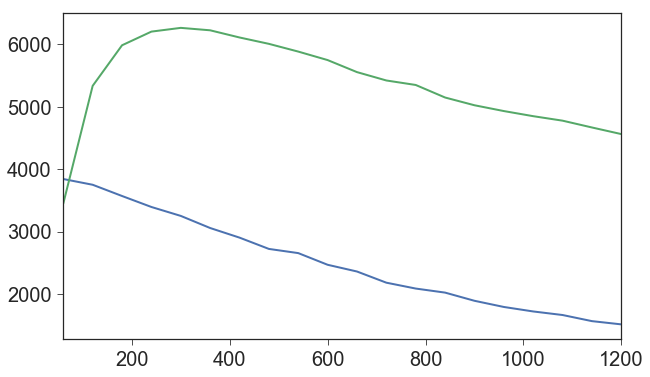

In [174]:
split_components.plot()
num_components.plot()

In [190]:
print("Interval splitting splits {:.0f}% of temporal components".format(100*(split_components/4137)[1200]))

Interval splitting splits 37% of temporal components


## 7. Comparison with time-shuffled data

See ``ensemble.ipynb`` for data generation.

In [94]:
# Load feature vectors from precomputed ensembles
feature_store = pd.read_csv('./data/random/ensemble_features.csv', header=0, index_col=0)
scale_feature_store = pd.read_csv('./data/random/ensemble_scale_features.csv', header=0, index_col=0)
complete = pd.read_csv('./data/random/ensemble_complete.csv', header=0, index_col=0)

In [95]:
sample_vector = feature_store['sample']
feature_store = feature_store.loc[:,features.columns].fillna(0)
scale_feature_store = scale_feature_store.loc[:,scale_features.columns].fillna(0)
complete = complete.loc[:,features.columns].fillna(0)

In [96]:
# Rescale
rs_feature_store = Normalizer().fit_transform(feature_store)
rs_feature_store = pd.DataFrame(rs_feature_store, index=feature_store.index, columns=feature_store.columns)

rs_complete = Normalizer().fit_transform(complete)
rs_complete = pd.DataFrame(rs_complete, index=complete.index, columns=complete.columns)

In [97]:
distances = {}
for sample, group in rs_feature_store.groupby(sample_vector):
    distances[sample] = ((group - rs_complete.loc[sample])**2).sum(axis=1)

In [98]:
# Actual data distance
full, _ = generate_features({'full': filtered}, feature_spec=FEATURE_SPEC)

rs_full = Normalizer().fit_transform(full)
rs_full = pd.DataFrame(rs_full, index=full.index, columns=full.columns)

actual_distance = (rs_features.subtract(rs_full.T.values[:,0])**2).sum(axis=1)

In [99]:
actual_distance.mean(), actual_distance.var(), len(actual_distance)

(0.698969691938939, 0.04069528800159395, 4137)

### FIGURE (omitted)

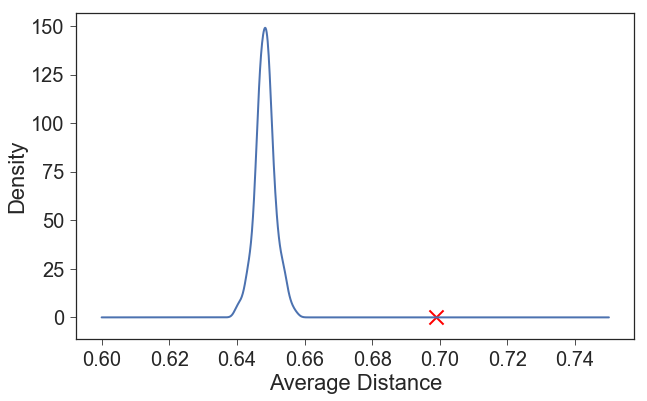

In [105]:
from scipy.stats import gaussian_kde

d = pd.Series([d.mean() for d in distances.values()])
kde = gaussian_kde(d)

x = np.linspace(0.6, 0.75,1000)

y = kde.evaluate(x)

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)

ax.plot(x,y)
ax.scatter([actual_distance.mean()],[0], marker='x', color='r', s=200)

ax.set_xlabel("Average Distance")
ax.set_ylabel("Density")

fig.savefig('./figures/figure_8_distance.eps', bbox_inches='tight')

In [146]:
# z-score
d.mean(), d.std(), (actual_distance.mean() - d.mean())/ d.std()

(0.648369298701186, 0.002906663918284486, 17.408408629373763)

Average # Components: 3529.75
Average Duration: 535.763596809282 (original) v 744.1990891706212 (random)
Average # Events: 21.12303601643703 (original) v 13.664428075642752 (random)


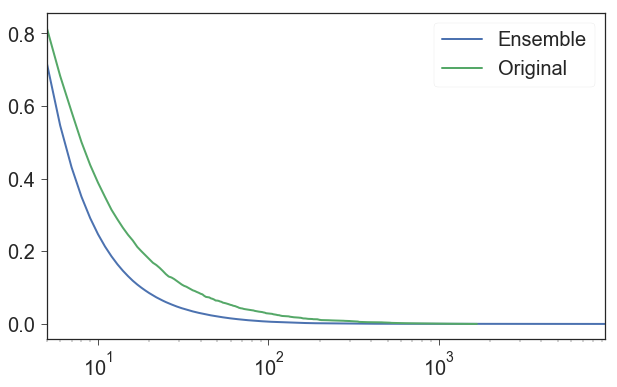

In [187]:
# Temporal Component Sizes 

(1-scale_feature_store.num_events.value_counts(normalize=True).sort_index().cumsum()).plot(logx=True, logy=False, label='Ensemble', legend=True)
(1-scale_features.num_events.value_counts(normalize=True).sort_index().cumsum()).plot(label='Original', legend=True)

print("Average # Components: {}".format(len(feature_store)/200))
print("Average Duration: {} (original) v {} (random)".format(scale_features.duration.mean(), scale_feature_store.duration.mean()))
print("Average # Events: {} (original) v {} (random)".format(scale_features.num_events.mean(), scale_feature_store.num_events.mean()))

### FIGURE 8 - Feature Densities

In [103]:
full = pd.concat([rs_features, rs_feature_store])
X, PCA = reduce_feature_dimensionality(full, ndim=2, return_scalers=True)

Y = PCA.fit_transform(rs_features)
X = PCA.fit_transform(rs_feature_store)

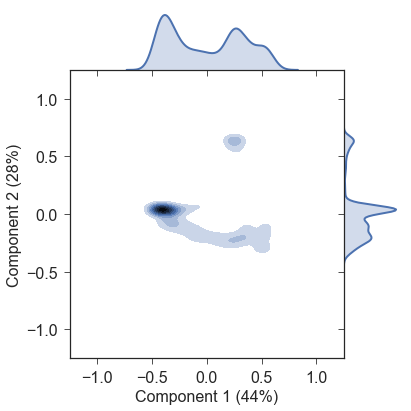

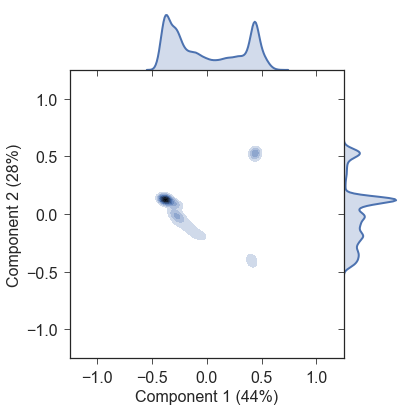

In [104]:
z = pd.DataFrame(Y)
zr = pd.DataFrame(X).sample(100000, random_state=0)

r = 1.25
xmin,xmax = -r,r
ymin,ymax = -r,r

with plt.style.context(['seaborn-paper', PLOT_STYLE]):

    for dat, counter, name in ((z,'a','data'),(zr,'b','ensemble')):

        g = sns.jointplot(x=0, 
                      y=1, 
                      data=dat, 
                      kind='kde', 
                      stat_func=None, 
                      xlim=(xmin,xmax), 
                      ylim=(ymin,ymax),
                      shade_lowest=False,
                      size=6, 
                      space=0,
                      );
        
        g.ax_joint.axes.set_xticks(np.linspace(-1,1,5))
        g.ax_joint.axes.set_yticks(np.linspace(-1,1,5))

        g.set_axis_labels("Component 1 ({:.0f}%)".format(100*PCA.explained_variance_ratio_[0]),
                          "Component 2 ({:.0f}%)".format(100*PCA.explained_variance_ratio_[1]))
    
        g.savefig('./figures/figure_a3{}_density{}.eps'.format(counter, name))